In [ ]:
# cell 1 — окружение
# обновим pip, установим ultralytics (YOLOv8), и необходимые пакеты
!pip install -U pip
!pip install -U ultralytics==8.*   # YOLOv8 (ultralytics). Если версия изменится, можно убрать ==8.*
!pip install -U roboflow jsonschema tqdm
# Убедимся, что torch видит GPU
import torch
print("Torch:", torch.__version__, "CUDA available:", torch.cuda.is_available())


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 33.2 MB/s eta 0:00:00
  Attempting uninstall: pip
    Found existing installation: pip 24.1.2
    Uninstalling pip-24.1.2:
      Successfully uninstalled pip-24.1.2
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 9.8 MB/s  0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2/2 [ultralytics]
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.9/49.9 MB 72.5 MB/s  0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 71.6 MB/s  0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.2/4.2 MB 107.8 MB/s  0:00:00
  Attempting uninstall: opencv-python-headless
    Found existing installation: opencv-python-headless 4.12.0.88
    Uninstalling opencv-python-headless-4.12.0.88:
      Successfully uninstalled opencv-python-headless-4.12.0.88
  Attempting uninstall: idna
    Found existing installation: idna 3.11
    Uninstalling idna-3.11:
      Successfully uninstalled idna-3.11
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6/6 [ro

In [ ]:

import os, glob, pprint

BASE = '/content/drive/MyDrive/CV_TZ'
paths = {
    'images_train': os.path.join(BASE, 'Изображения', 'Train'),
    'images_test' : os.path.join(BASE, 'Изображения', 'Test'),
    'labels_train': os.path.join(BASE, 'Разметка', 'Train'),
    'labels_test' : os.path.join(BASE, 'Разметка', 'Test'),
}
pprint.pprint(paths)

# quick checks
for k,p in paths.items():
    if os.path.exists(p):
        files = sum([len(glob.glob(os.path.join(p, ext))) for ext in ('*.jpg','*.jpeg','*.png')]) if 'images' in k else len(glob.glob(os.path.join(p,'*.txt')))
        print(f"{k}: {p} -> {files} files")
    else:
        print(f"{k}: NOT FOUND -> {p}")


{'images_test': '/content/drive/MyDrive/CV_TZ/Изображения/Test',
 'images_train': '/content/drive/MyDrive/CV_TZ/Изображения/Train',
 'labels_test': '/content/drive/MyDrive/CV_TZ/Разметка/Test',
 'labels_train': '/content/drive/MyDrive/CV_TZ/Разметка/Train'}
images_train: /content/drive/MyDrive/CV_TZ/Изображения/Train -> 50 files
images_test: /content/drive/MyDrive/CV_TZ/Изображения/Test -> 10 files
labels_train: /content/drive/MyDrive/CV_TZ/Разметка/Train -> 50 files
labels_test: /content/drive/MyDrive/CV_TZ/Разметка/Test -> 10 files


In [ ]:
# cell 2
import os, glob, shutil

SRC_IM_TRAIN = paths['images_train']
SRC_IM_VAL   = paths['images_test']
SRC_LB_TRAIN = paths['labels_train']
SRC_LB_VAL   = paths['labels_test']

DST = '/content/dataset'   # рабочий датасет
imgs_train_dst = os.path.join(DST, 'images', 'train')
imgs_val_dst   = os.path.join(DST, 'images', 'val')
labels_train_dst = os.path.join(DST, 'labels', 'train')
labels_val_dst   = os.path.join(DST, 'labels', 'val')

for d in [imgs_train_dst, imgs_val_dst, labels_train_dst, labels_val_dst]:
    os.makedirs(d, exist_ok=True)

# helper: copy images (any ext)
def copy_images(src_folder, dst_folder):
    exts = ('*.jpg','*.jpeg','*.png','*.bmp')
    count = 0
    for e in exts:
        for f in glob.glob(os.path.join(src_folder, e)):
            shutil.copy(f, os.path.join(dst_folder, os.path.basename(f)))
            count += 1
    return count

print("Copy train images:", copy_images(SRC_IM_TRAIN, imgs_train_dst))
print("Copy val images:  ", copy_images(SRC_IM_VAL, imgs_val_dst))

# convert labels: replace leading '15 ' -> '0 ' and '16 ' -> '1 '
def convert_and_copy_labels(src_folder, dst_folder):
    txts = glob.glob(os.path.join(src_folder, '*.txt'))
    missing_images = []
    for t in txts:
        name = os.path.basename(t)
        base = os.path.splitext(name)[0]
        # find image counterpart in train/val images (we assume extensions may vary)
        # ensure label copied only if image exists in dst (safe)
        # we'll always copy converted label to dst
        with open(t, 'r', encoding='utf-8') as fin:
            lines = fin.read().splitlines()
        new_lines = []
        for L in lines:
            L = L.strip()
            if not L:
                continue
            parts = L.split()
            cls = parts[0]
            if cls == '15': cls2 = '0'
            elif cls == '16': cls2 = '1'
            else:
                # Если встречаются другие классы, напечатаем предупреждение и пропустим
                cls2 = cls
                print("Warning: unexpected class", cls, "in", t)
            new_lines.append(' '.join([cls2]+parts[1:]))
        with open(os.path.join(dst_folder, name), 'w', encoding='utf-8') as fout:
            fout.write('\n'.join(new_lines))
    return len(txts)

print("Convert+copy train labels:", convert_and_copy_labels(SRC_LB_TRAIN, labels_train_dst))
print("Convert+copy val labels:  ", convert_and_copy_labels(SRC_LB_VAL, labels_val_dst))

# final counts
print("Final counts:")
print("images/train:", len(glob.glob(os.path.join(imgs_train_dst,'*'))))
print("labels/train:", len(glob.glob(os.path.join(labels_train_dst,'*.txt'))))
print("images/val:  ", len(glob.glob(os.path.join(imgs_val_dst,'*'))))
print("labels/val:  ", len(glob.glob(os.path.join(labels_val_dst,'*.txt'))))


Copy train images: 50
Copy val images:   10
Convert+copy train labels: 50
Convert+copy val labels:   10
Final counts:
images/train: 50
labels/train: 50
images/val:   10
labels/val:   10


In [ ]:
# cell 3
data_yaml = {
    'path': '/content/dataset',
    'train': 'images/train',
    'val':   'images/val',
    'nc': 2,
    'names': ['pen', 'pencil']
}
import yaml
with open('/content/data.yaml', 'w', encoding='utf-8') as f:
    yaml.safe_dump(data_yaml, f, sort_keys=False, allow_unicode=True)
print("Created /content/data.yaml:")
print(open('/content/data.yaml','r',encoding='utf-8').read())


Created /content/data.yaml:
path: /content/dataset
train: images/train
val: images/val
nc: 2
names:
- pen
- pencil



In [ ]:
# cell 4
from ultralytics import YOLO
import os

# гиперпараметры (настрой под доступную память)
epochs = 50
imgsz = 640
batch = 8   # уменьшай, если OOM
device = 0  # GPU device

runs_root = '/content/runs_yolo'
os.makedirs(runs_root, exist_ok=True)

# 1) yolov8n
model_n = YOLO('yolov8n.pt')
print("Train yolov8n ...")
res_n = model_n.train(data='/content/data.yaml', epochs=epochs, imgsz=imgsz, batch=batch, project=runs_root, name='yolov8n_pen_pencil', device=device)

# 2) yolov8s
model_s = YOLO('yolov8s.pt')
print("Train yolov8s ...")
res_s = model_s.train(data='/content/data.yaml', epochs=epochs, imgsz=imgsz, batch=batch, project=runs_root, name='yolov8s_pen_pencil', device=device)


Train yolov8n ...
Ultralytics 8.3.221 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=8, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/content/data.yaml, degrees=0.0, deterministic=True, device=0, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=50, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolov8n.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=yolov8n_pen_pencil2, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, overlap_mask=True, patience=100, perspective=0.0, 

In [ ]:
from ultralytics import YOLO
import os, glob, pprint

def get_best_weight(run_name):
    path = f"/content/runs_yolo/{run_name}/weights/best.pt"
    if os.path.exists(path):
        return path
    weights = glob.glob(f"/content/runs_yolo/{run_name}/weights/*.pt")
    return weights[0] if weights else None

run_n = "yolov8n_pen_pencil"
run_s = "yolov8s_pen_pencil"

best_n = get_best_weight(run_n)
best_s = get_best_weight(run_s)

print("best_n:", best_n)
print("best_s:", best_s)

def evaluate_model(weights_path, model_name):
    model = YOLO(weights_path)
    results = model.val(data="/content/data.yaml", imgsz=640, batch=8, device=0)

    print(f"\n📊 Метрики для {model_name}:")
    mp, mr, map50, map = results.box.mean_results()
    print(f"Precision (mp):       {mp:.3f}")
    print(f"Recall (mr):          {mr:.3f}")
    print(f"mAP@0.5:              {map50:.3f}")
    print(f"mAP@0.5:0.95:         {map:.3f}")

    # mAP по каждому классу
    print("\n🔹 mAP по классам (в порядке индексов классов):")
    pprint.pprint(results.box.maps)

if best_n:
    evaluate_model(best_n, "YOLOv8n")

if best_s:
    evaluate_model(best_s, "YOLOv8s")


best_n: None
best_s: /content/runs_yolo/yolov8s_pen_pencil/weights/best.pt
Ultralytics 8.3.221 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
Model summary (fused): 72 layers, 11,126,358 parameters, 0 gradients, 28.4 GFLOPs
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 1904.7±855.4 MB/s, size: 121.4 KB)
val: Scanning /content/dataset/labels/val.cache... 10 images, 0 backgrounds, 0 corrupt: 100% ━━━━━━━━━━━━ 10/10 8.6Kit/s 0.0s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 2/2 2.7it/s 0.7s
                   all         10         20      0.992          1      0.995      0.882
                   pen         10         10       0.99          1      0.995      0.865
                pencil         10         10      0.994          1      0.995        0.9
Speed: 11.9ms preprocess, 13.8ms inference, 0.0ms loss, 3.3ms postprocess per image
Results saved to /content/runs/detect/val5

📊 Метрики для YOLOv8s:
Precis

Выбрано изображение: /content/drive/MyDrive/CV_TZ/Изображения/Test

image 1/10 /content/drive/MyDrive/CV_TZ/Изображения/Test/0c710cdb-aef6-414d-8704-c9b2585aed7b.jpg: 640x480 1 pen, 1 pencil, 13.6ms
image 2/10 /content/drive/MyDrive/CV_TZ/Изображения/Test/0e67fa7b-0132-4ed2-9ab2-1179c347ac79.jpg: 640x480 1 pen, 1 pencil, 12.2ms
image 3/10 /content/drive/MyDrive/CV_TZ/Изображения/Test/0f2bae12-f028-4c67-86b4-3f56b1ecb4f7.jpg: 640x480 1 pen, 1 pencil, 12.1ms
image 4/10 /content/drive/MyDrive/CV_TZ/Изображения/Test/2ed9bf3a-bf81-4a4a-a22d-2be8bfaf2fe9.jpg: 640x480 1 pen, 1 pencil, 12.2ms
image 5/10 /content/drive/MyDrive/CV_TZ/Изображения/Test/2f7a84bb-102c-43a2-9613-6bfda7188d16.jpg: 640x480 1 pen, 1 pencil, 12.2ms
image 6/10 /content/drive/MyDrive/CV_TZ/Изображения/Test/3c4d1bd2-619c-45ec-ab54-049579b92594.jpg: 640x480 1 pen, 1 pencil, 12.2ms
image 7/10 /content/drive/MyDrive/CV_TZ/Изображения/Test/5b62c180-c76a-46fd-a54f-5125f6b3a974.jpg: 640x480 1 pen, 1 pencil, 12.2ms
image 8/10 /con

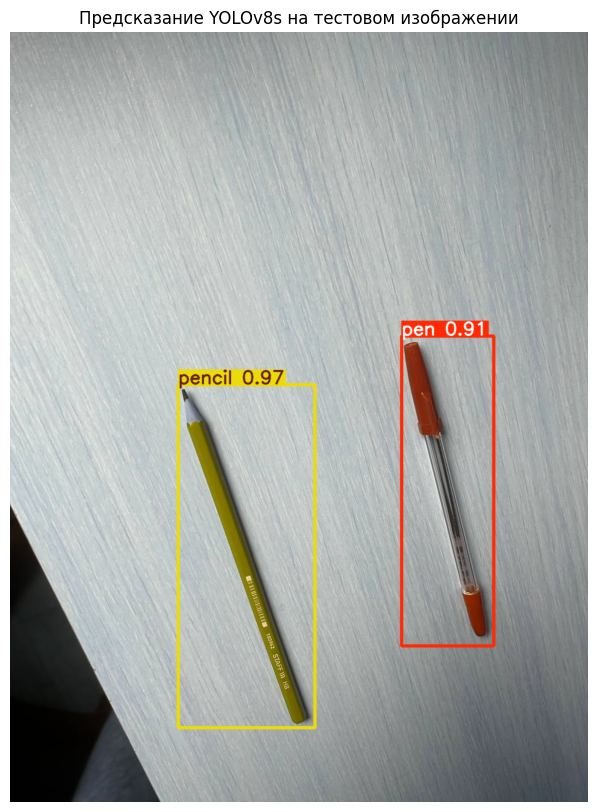

In [ ]:
import random, glob
import matplotlib.pyplot as plt
from ultralytics import YOLO
from PIL import Image

# 🔹 Путь к изображениям тестового набора
test_images = glob.glob("/content/drive/MyDrive/CV_TZ/Изображения/Test")

# 🔹 Выбираем случайное изображение
img_path = random.choice(test_images)
print(f"Выбрано изображение: {img_path}")

# 🔹 Загружаем лучшую модель (например, YOLOv8s)
model = YOLO("/content/runs_yolo/yolov8s_pen_pencil/weights/best.pt")

# 🔹 Получаем предсказания
results = model(img_path, conf=0.25)  # conf можно регулировать (0.25–0.5)

# 🔹 Отображаем результат с разметкой
annotated_frame = results[0].plot()  # рисует боксы и метки классов

plt.figure(figsize=(10, 10))
plt.imshow(annotated_frame)
plt.axis("off")
plt.title("Предсказание YOLOv8s на тестовом изображении")
plt.show()


In [ ]:
# =====================================
# 🔹 Установка и импорт
# =====================================
from ultralytics import YOLO
import glob, os
from IPython.display import Video, display

# =====================================
# 🔹 Функция для показа последнего обработанного видео
# =====================================
def show_last_detected_video(base_dir="/content"):
    # Ищем любые видеофайлы
    videos = sorted(
        glob.glob(os.path.join(base_dir, "**/*.*"), recursive=True),
        key=os.path.getmtime,
        reverse=True
    )
    # Фильтруем только mp4, mov, avi и mkv
    videos = [v for v in videos if v.lower().endswith((".mp4", ".mov", ".avi", ".mkv"))]

    if not videos:
        print("⚠️ Видео не найдено. Убедись, что YOLO отработал с параметром save=True.")
        return

    # Берём самое свежее
    latest_video = videos[0]
    print(f"✅ Найдено видео: {latest_video}")

    # Показываем прямо в Colab
    display(Video(latest_video, embed=True))

# =====================================
# 🔹 Обработка видео YOLO-моделью
# =====================================
# Укажи путь к своему .MOV-файлу
video_path = "/content/IMG_4444.MOV"  # <-- замени на свой путь

# Загружаем обученную модель
model_path = "/content/runs_yolo/yolov8s_pen_pencil/weights/best.pt"  # <-- путь к твоим весам
model = YOLO(model_path)

# Запускаем детекцию и сохраняем результат
results = model.predict(
    source=video_path,
    conf=0.25,
    save=True,
    project="/content",
    name="detected_video",
    exist_ok=True
)

# =====================================
# 🔹 Показываем последнее сохранённое видео
# =====================================
show_last_detected_video()



WARNING ⚠️ 
inference results will accumulate in RAM unless `stream=True` is passed, causing potential out-of-memory
errors for large sources or long-running streams and videos. See https://docs.ultralytics.com/modes/predict/ for help.

Example:
    results = model(source=..., stream=True)  # generator of Results objects
    for r in results:
        boxes = r.boxes  # Boxes object for bbox outputs
        masks = r.masks  # Masks object for segment masks outputs
        probs = r.probs  # Class probabilities for classification outputs

video 1/1 (frame 1/923) /content/IMG_4444.MOV: 640x384 1 pen, 1 pencil, 13.6ms
video 1/1 (frame 2/923) /content/IMG_4444.MOV: 640x384 1 pen, 1 pencil, 12.8ms
video 1/1 (frame 3/923) /content/IMG_4444.MOV: 640x384 1 pen, 1 pencil, 11.8ms
video 1/1 (frame 4/923) /content/IMG_4444.MOV: 640x384 1 pen, 1 pencil, 23.7ms
video 1/1 (frame 5/923) /content/IMG_4444.MOV: 640x384 1 pen, 1 pencil, 11.9ms
video 1/1 (frame 6/923) /content/IMG_4444.MOV: 640x384 1 pen,